# Evidence of Reasonable model - kNN

We perform a set of experiments to see if the data is classifiable and can be differentiated in the catgories mentioned. In this file, we use the kNN classifier to study the data.

The following sections present our process of extracting the combined dataset (combination of data done in data_preprocessing.ipynb) from the relvant train and test files. The train and test split has been pre-done by the providers of the dataset by manually filtering out data from certain drivers (not seen in the train set) as the test set. We sample out 1255 images from the train test consisting of 12555 images and use this randomly generated, label stratified sample for our experiments. The images are preporcessed to extract the figure of the driver and set all the surroundings to black. This preprocessed data is then fed into the model, hyperparameters are tuned and the final best model is tested against the test data. The results are presented as a classification report and a confusion matrix. 

In [91]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, get_scorer_names
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import torch
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from torchvision import transforms
from sklearn.decomposition import PCA

torch.cuda.empty_cache()
torch.cuda.is_available()

True

## Extracting the Data

The images stored in the combined dataset are extracted into separate train and test set paths.

NOTE: Before running this file, please unzip the Distacted Driver Dataset that contained the combined dataset.

In [2]:
CLASS = [["c0", "Safe Driving"], ["c1", "Text"], ["c2", "Phone"], 
         ["c3", "Adjusting Radio"], ["c4", "Drinking"], 
         ["c5", "Reaching Behind"], ["c6", "Hair or Makeup"], 
         ["c7", "Talking to Passenger"]]
TEST_CLS = [os.path.join(os.getcwd(), "Distracted Driver Dataset", "Combined", "test", cls[0]) for cls in CLASS]
TRAIN_CLS = [os.path.join(os.getcwd(), "Distracted Driver Dataset", "Combined", "train", cls[0]) for cls in CLASS]
for cls_path in TEST_CLS:
  print(cls_path)
  print(len(os.listdir(cls_path)))
for cls_path in TRAIN_CLS:
  print(cls_path)
  print(len(os.listdir(cls_path)))

c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c0
346
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c1
393
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c2
364
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c3
170
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c4
143
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c5
143
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\CS3244-Group-8-Project-2\Distracted Driver Dataset\Combined\test\c6
146
c:\Users\wamik\Documents\Notes Y4S2\CS3244\Projects\Project 2\

For each class, the path of the training and test data is stored in separate lists. The corresponding labels are also stored in a different list

In [3]:
train_paths = []
test_paths = []
for cls in range(8):
  for train_instance in os.listdir(TRAIN_CLS[cls]):
    train_paths.append(os.path.join(TRAIN_CLS[cls], train_instance))
  for test_instance in os.listdir(TEST_CLS[cls]):
    test_paths.append(os.path.join(TEST_CLS[cls], test_instance))

In [4]:
classes = []
test_classes = []
for cls in range(8):
  for train_instance in os.listdir(TRAIN_CLS[cls]):
    classes.append(cls)
  for test_instance in os.listdir(TEST_CLS[cls]):
    test_classes.append(cls)

Then separate dataframes storing the train and test paths with their corresponding labels are created.

In [5]:
df = pd.DataFrame({
  'filename': train_paths,
  'class': classes
})
df

,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
12550,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
12551,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
12552,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
12553,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7


In [6]:
df_test = pd.DataFrame({
  'filename': test_paths,
  'class': test_classes
})
df_test

,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
1918,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
1919,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
1920,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
1921,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7


The below plots show us the frequency of each class in the dataset. As can be seen from the plots, the dataset is not balanced. Keeping this in mind, we use evaluation metrics like recall and precision along with accuracy to get better insights on performance.

<AxesSubplot:>

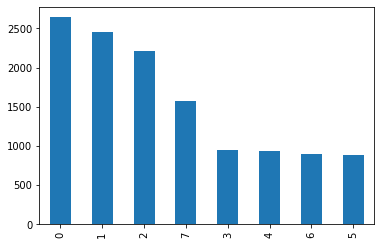

In [7]:
df['class'].value_counts().plot.bar()

<AxesSubplot:>

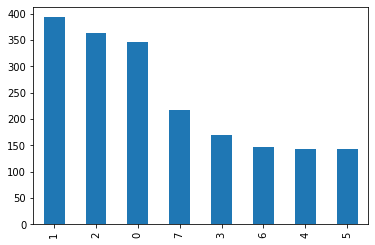

In [8]:
df_test['class'].value_counts().plot.bar()

In [9]:
df_all_data = pd.concat([df, df_test], ignore_index=True)
df_all_data

,filename,class
0,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
1,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
2,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
3,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
4,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,0
...,...,...
14473,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
14474,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
14475,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7
14476,c:\Users\wamik\Documents\Notes Y4S2\CS3244\Pro...,7


## Data Preprocessing

First, we convert the images from RGB to Gray and then perform appropriate resizing based on a calculated scale. Tehn, we use the pytorch's DeeplabV3 neural network to extract the shape of the driver, these are represented as pixels marked true in the _mask_. [source](https://v-hramchenko.medium.com/how-to-cut-out-a-person-in-an-image-with-open-source-projects-e5e7f8798d5c)

The pixels in the gray resized image corresponding to these true pixels are then extracted and the rest of the pixels are set to black. As such we get images with the driver cropped out and background set to black. This will help the model to focus on the expected regions of the image to appropriated detect distracted behaviour.

Note: The code in this section  needs to be run only once. If you already have "first_half_processed_imgs.npy", "scnd_half_processed_imgs.npy", "sampled_labels.npy", DO NOT run this section. Skip to _Loading Final Data_.

In [10]:
def make_deeplab(device):
    deeplab = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT).to(device)
    deeplab.eval()
    return deeplab

device = torch.device("cuda")
deeplab = make_deeplab(device)

In [11]:
deeplab_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def apply_deeplab(deeplab, img, device):
    input_tensor = deeplab_preprocess(img)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        output = deeplab(input_batch.to(device))['out'][0]
    output_predictions = output.argmax(0).cuda().to("cpu")
    output_predictions = output_predictions.numpy()
    return (output_predictions == 15)

We first test out our proposed idea on a sample image, the results of which are shown below. It can be seen that the driver is cropped out of the image and the background is removed (set to black).

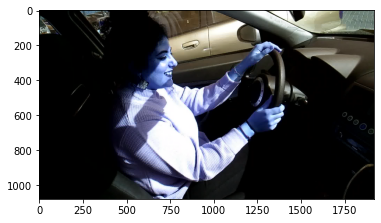

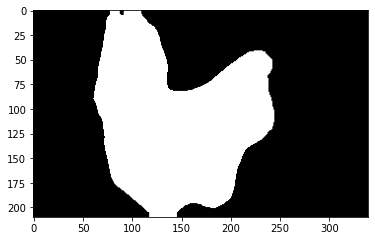

(210, 340, 3)
(210, 340, 3)


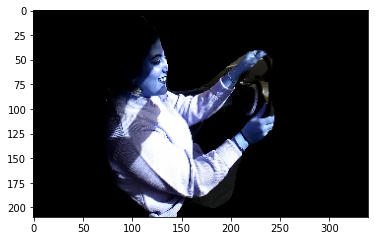

In [12]:
img_orig = cv2.imread(df['filename'].iloc[0], cv2.COLOR_RGB2GRAY)
plt.imshow(img_orig)
plt.show()
k = min(1.0, 1024/max(img_orig.shape[0], img_orig.shape[1]))
img = cv2.resize(img_orig, (340, 210), fx=k, fy=k, interpolation=cv2.INTER_LANCZOS4)

# Running the deeplab model on a sample image
mask = apply_deeplab(deeplab, img, device)

plt.imshow(mask, cmap='gray')
plt.show()

# Only choose pixels of the gray image that correspond to true pixels of the mask. Rest are set to rgb 0, 0, 0, i.e., black.
print(np.asarray(img).shape)
img_seg = []
for i in range(len(mask)):
    pixels = []
    for j in range(len(mask[i])):
        if mask[i][j]:
            pixels.append(img[i][j])
        else:
            pixels.append([0, 0, 0])
    img_seg.append(pixels)
    
img_seg = np.asarray(img_seg)
print(img_seg.shape)
plt.imshow(img_seg)

We now perform a similar process on all sets of the training data. Before doing so, we first convert the images into 2D pixels with the appropriate color to gray transformation and resizing. This is done so that the 1255 samples can be randomly selected using _train_test_split()_.

In [13]:
X_train_final = []
Y_test = []
for index, path in df.iterrows():
    img_orig = cv2.imread(path[0], cv2.COLOR_RGB2GRAY)
    k = min(1.0, 1024/max(img_orig.shape[0], img_orig.shape[1]))
    img = cv2.resize(img_orig, (340, 210), fx=k, fy=k, interpolation=cv2.INTER_LANCZOS4)
    if (index+1) % 135 == 0:
        print("Processed ", index + 1, "images. Continuing...")
    X_train_final.append(np.asarray(img))
    Y_test.append(path[1])

print("Done!")

Processed  135 images. Continuing...
Processed  270 images. Continuing...
Processed  405 images. Continuing...
Processed  540 images. Continuing...
Processed  675 images. Continuing...
Processed  810 images. Continuing...
Processed  945 images. Continuing...
Processed  1080 images. Continuing...
Processed  1215 images. Continuing...
Processed  1350 images. Continuing...
Processed  1485 images. Continuing...
Processed  1620 images. Continuing...
Processed  1755 images. Continuing...
Processed  1890 images. Continuing...
Processed  2025 images. Continuing...
Processed  2160 images. Continuing...
Processed  2295 images. Continuing...
Processed  2430 images. Continuing...
Processed  2565 images. Continuing...
Processed  2700 images. Continuing...
Processed  2835 images. Continuing...
Processed  2970 images. Continuing...
Processed  3105 images. Continuing...
Processed  3240 images. Continuing...
Processed  3375 images. Continuing...
Processed  3510 images. Continuing...
Processed  3645 ima

In [14]:
print(len(Y_test))

12555


In [15]:
data_arr = np.asarray(X_train_final)
print(data_arr.shape)
# data_arr = data_arr.reshape(data_arr.shape[0], -1)
labels_arr = np.asarray(Y_test)

(12555, 210, 340, 3)


In [16]:
(X_train, X_test, Y_train, Y_test) = train_test_split(data_arr, labels_arr, test_size=0.9, stratify=Y_test, random_state=42)
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
print(X_train.shape)
print(Y_train.shape)

(1255, 210, 340, 3)
(1255,)


We process the data in 2 parts due to processing time and power constraints. Each half is stored in a separate .npy file.

In [17]:
X_train_processed = []
done = 0
for img in X_train[0:627]:
    done+=1
    mask = apply_deeplab(deeplab, img, device)
    img_seg = []
    for i in range(len(mask)):
        pixels = []
        for j in range(len(mask[i])):
            if mask[i][j]:
                pixels.append(img[i][j])
            else:
                pixels.append([0, 0, 0])
        img_seg.append(pixels)
    X_train_processed.append(img_seg)
    print("Processed ", done, " images. Continuing...") 

X_train_processed = np.asarray(X_train_processed)
print(X_train_processed.shape)

Processed  1  images. Continuing...
Processed  2  images. Continuing...
Processed  3  images. Continuing...
Processed  4  images. Continuing...
Processed  5  images. Continuing...
Processed  6  images. Continuing...
Processed  7  images. Continuing...
Processed  8  images. Continuing...
Processed  9  images. Continuing...
Processed  10  images. Continuing...
Processed  11  images. Continuing...
Processed  12  images. Continuing...
Processed  13  images. Continuing...
Processed  14  images. Continuing...
Processed  15  images. Continuing...
Processed  16  images. Continuing...
Processed  17  images. Continuing...
Processed  18  images. Continuing...
Processed  19  images. Continuing...
Processed  20  images. Continuing...
Processed  21  images. Continuing...
Processed  22  images. Continuing...
Processed  23  images. Continuing...
Processed  24  images. Continuing...
Processed  25  images. Continuing...
Processed  26  images. Continuing...
Processed  27  images. Continuing...
Processed 

In [18]:
np.save("first_half_processed_imgs.npy", X_train_processed)

In [19]:
X_train_processed = []
done = 0
for img in X_train[627:]:
    done+=1
    mask = apply_deeplab(deeplab, img, device)
    img_seg = []
    for i in range(len(mask)):
        pixels = []
        for j in range(len(mask[i])):
            if mask[i][j]:
                pixels.append(img[i][j])
            else:
                pixels.append([0, 0, 0])
        img_seg.append(pixels)
    X_train_processed.append(img_seg)
    print("Processed ", done, " images. Continuing...") 

X_train_processed = np.asarray(X_train_processed)
print(X_train_processed.shape)

Processed  1  images. Continuing...
Processed  2  images. Continuing...
Processed  3  images. Continuing...
Processed  4  images. Continuing...
Processed  5  images. Continuing...
Processed  6  images. Continuing...
Processed  7  images. Continuing...
Processed  8  images. Continuing...
Processed  9  images. Continuing...
Processed  10  images. Continuing...
Processed  11  images. Continuing...
Processed  12  images. Continuing...
Processed  13  images. Continuing...
Processed  14  images. Continuing...
Processed  15  images. Continuing...
Processed  16  images. Continuing...
Processed  17  images. Continuing...
Processed  18  images. Continuing...
Processed  19  images. Continuing...
Processed  20  images. Continuing...
Processed  21  images. Continuing...
Processed  22  images. Continuing...
Processed  23  images. Continuing...
Processed  24  images. Continuing...
Processed  25  images. Continuing...
Processed  26  images. Continuing...
Processed  27  images. Continuing...
Processed 

In [20]:
np.save("scnd_half_processed_imgs.npy", X_train_processed)
np.save("sampled_labels.npy", Y_train)

In [30]:
X_train_1 = np.load("first_half_processed_imgs.npy")
X_train_2 = np.load("scnd_half_processed_imgs.npy")
Y_train = np.load("sampled_labels.npy")
X_train_final = np.concatenate((X_train_1, X_train_2))
X_train_final = X_train_final.reshape(X_train_final.shape[0], -1)
X_train_final.shape

(1255, 214200)

We Reduce the dimensions of the data using Principal Component Analysis (PCA).

In [31]:
pca_dims = PCA()
pca_dims.fit(X_train_final)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [32]:
d

514

In [33]:
pca = PCA(n_components=d)
X_train_reduced = pca.fit_transform(X_train_final)

In [34]:
np.save("processed_imgs.npy", X_train_reduced)
np.save("sampled_labels.npy", Y_train)

## Loading Final Data

In [59]:
Y_train = np.load("sampled_labels.npy")
X_train_final = np.load("processed_imgs.npy")
X_train_final.shape

(1255, 514)

In [60]:
X_train_final = X_train_final.reshape(X_train_final.shape[0], -1)
X_train_final.shape

(1255, 514)

## kNN Model

We choose to do trial and error for choosing the best hyperparameters due to the nature of the data. The training set has drivers that the model has already seen, hence doing a validation split on the training set may result in overfitting to drivers' facial features.

In [120]:
# print(get_scorer_names())
# parameters_knn = {'n_neighbors': range(5, 25), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'chebyshev', 'manhattan']}

# clf_knn = GridSearchCV(KNeighborsClassifier(), param_grid=parameters_knn, cv=5, n_jobs=-1, scoring="v_measure_score", verbose=10)

# clf_knn.fit(X=X_train_final, y=Y_train)

# print ("The best acc for KNN:", clf_knn.best_score_ * 100, "%, with", clf_knn.best_params_) 

In [118]:
clf_knn = KNeighborsClassifier(n_neighbors = 10, weights = 'distance')
clf_knn.fit(X_train_final, Y_train)
print(clf_knn.classes_)

[0 1 2 3 4 5 6 7]


## Performance Evaluation

### Preparing Test Data

Test data is prepared in the same manner as the training data. Run this section only once to generate the .npy files.

In [48]:
X_test_processed = []
Y_test = []
for index, path in df_test.iterrows():
    img_orig = cv2.imread(path[0], cv2.COLOR_RGB2GRAY)
    k = min(1.0, 1024/max(img_orig.shape[0], img_orig.shape[1]))
    img = cv2.resize(img_orig, (340, 210), fx=k, fy=k, interpolation=cv2.INTER_LANCZOS4)
    if (index+1) % 135 == 0:
        print("Processed ", index + 1, "images. Continuing...")
    X_test_processed.append(np.asarray(img))
    Y_test.append(path[1])

print("Done!")

Processed  135 images. Continuing...
Processed  270 images. Continuing...
Processed  405 images. Continuing...
Processed  540 images. Continuing...
Processed  675 images. Continuing...
Processed  810 images. Continuing...
Processed  945 images. Continuing...
Processed  1080 images. Continuing...
Processed  1215 images. Continuing...
Processed  1350 images. Continuing...
Processed  1485 images. Continuing...
Processed  1620 images. Continuing...
Processed  1755 images. Continuing...
Processed  1890 images. Continuing...
Done!


In [49]:
tdata_arr = np.asarray(X_test_processed)
print(tdata_arr.shape)
# data_arr = data_arr.reshape(data_arr.shape[0], -1)
tlabels_arr = np.asarray(Y_test)

(1923, 210, 340, 3)


In [50]:
(X_train, X_test, Y_test, Y_test) = train_test_split(tdata_arr, tlabels_arr, test_size=0.1, stratify=tlabels_arr, random_state=42)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
print(X_test.shape)
print(Y_test.shape)

(193, 210, 340, 3)
(193,)


In [51]:
X_test_processed = []
done = 0
for img in X_test:
    done+=1
    mask = apply_deeplab(deeplab, img, device)
    img_seg = []
    for i in range(len(mask)):
        pixels = []
        for j in range(len(mask[i])):
            if mask[i][j]:
                pixels.append(img[i][j])
            else:
                pixels.append([0, 0, 0])
        img_seg.append(pixels)
    X_test_processed.append(img_seg)
    print("Processed ", done, " images. Continuing...") 

X_test_processed = np.asarray(X_test_processed)
X_test_processed = X_test_processed.reshape(X_test_processed.shape[0], -1)
print(X_test_processed.shape)

Processed  1  images. Continuing...
Processed  2  images. Continuing...
Processed  3  images. Continuing...
Processed  4  images. Continuing...
Processed  5  images. Continuing...
Processed  6  images. Continuing...
Processed  7  images. Continuing...
Processed  8  images. Continuing...
Processed  9  images. Continuing...
Processed  10  images. Continuing...
Processed  11  images. Continuing...
Processed  12  images. Continuing...
Processed  13  images. Continuing...
Processed  14  images. Continuing...
Processed  15  images. Continuing...
Processed  16  images. Continuing...
Processed  17  images. Continuing...
Processed  18  images. Continuing...
Processed  19  images. Continuing...
Processed  20  images. Continuing...
Processed  21  images. Continuing...
Processed  22  images. Continuing...
Processed  23  images. Continuing...
Processed  24  images. Continuing...
Processed  25  images. Continuing...
Processed  26  images. Continuing...
Processed  27  images. Continuing...
Processed 

In [52]:
X_test_final = pca.transform(X_test_processed)
np.save("sampled_test_data.npy", X_test_final)
np.save("sampled_test_labels.npy", Y_test)

### Evaluating Performance

Since accuracy may not be the best indicator of model performance due to the imbalance in the dataset, we also use confusion matrix and classification report to further support our analysis.

In [84]:
X_test_processed = np.load("sampled_test_data.npy")
Y_test = np.load("sampled_test_labels.npy")
X_test_processed.shape

(193, 514)

In [119]:
print(clf_knn.score(X_test_processed, Y_test))
predictions = clf_knn.predict(X_test_processed)

0.35751295336787564


In [121]:
Y_test_new = []
for l in Y_test:
    if l!=0:
        Y_test_new.append(1)
    else:
        Y_test_new.append(0)
predictions_new = []
for pred in predictions:
    if pred!=0:
        predictions_new.append(1)
    else:
        predictions_new.append(0)

In [122]:
print(classification_report(Y_test_new, predictions_new))

              precision    recall  f1-score   support

           0       0.50      0.20      0.29        35
           1       0.84      0.96      0.90       158

    accuracy                           0.82       193
   macro avg       0.67      0.58      0.59       193
weighted avg       0.78      0.82      0.79       193



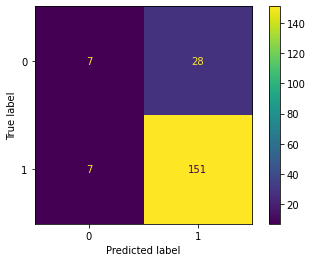

In [123]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


cm_knn = confusion_matrix(Y_test_new, predictions_new, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                               display_labels=[0, 1])  
disp.plot()

              precision    recall  f1-score   support

           0       0.50      0.20      0.29        35
           1       0.35      0.69      0.46        39
           2       0.25      0.35      0.30        37
           3       0.73      0.47      0.57        17
           4       0.60      0.21      0.32        14
           5       1.00      0.43      0.60        14
           6       0.23      0.20      0.21        15
           7       0.13      0.09      0.11        22

    accuracy                           0.36       193
   macro avg       0.47      0.33      0.36       193
weighted avg       0.42      0.36      0.35       193



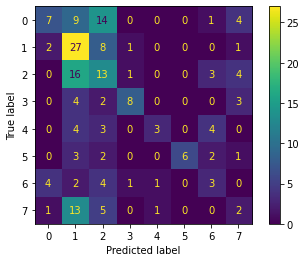

In [125]:
print(classification_report(Y_test, predictions))
cm_knn = confusion_matrix(Y_test, predictions, labels=clf_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn,
                               display_labels=clf_knn.classes_)  
disp.plot()

We get an accuracy of around 36% which is greater than the accuracy we can expect to get on random selection. Probability of getting a label right with random selection = 1/8 = 0.125. 12.5% < 36%. Moreover, the confusion matrix and classification report show that the model has f1 score > 30% for most labels and >50% for some. This provides further evidence that we more data preprocessing and feature engineering, we can classify the data. Hence, we have evidence that we can build a reasonable model for classifying the above dataset.